# Resampling

Allen Downey

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Inference by resampling

This notebook demonstrates a process for computing confidence intervals and standard errors by resampling.

As an example, we'll look at a survey question from the General Social Survey (GSS).

First, I'll load the dataset.

In [2]:
# Load the data file

import os

datafile = 'gss_eda.hdf5'
if not os.path.exists(datafile):
    !wget https://github.com/AllenDowney/PoliticalAlignmentCaseStudy/raw/master/gss_eda.hdf5

In [3]:
gss = pd.read_hdf(datafile, 'gss')
gss.shape

(64814, 169)

It includes 64814 respondents and 169 variables for each respondent.  This is the original dataset, before resampling.

## Is life exciting?

The variable we'll consider is [life](https://gssdataexplorer.norc.org/variables/438/vshow), which encodes reponses to this question:

> In general, do you find life exciting, pretty routine, or dull?


The responses are:

```
1	Exciting
2	Routine
3	Dull
```

Here's a summary of the responses:

In [4]:
life = gss['life']
life.describe()

count    39242.000000
mean         1.578742
std          0.586999
min          1.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          3.000000
Name: life, dtype: float64

I'll use the following function to compute the number of times each response appears.

In [5]:
def values(series, **options):
    """Count the values and sort.
    
    series: pd.Series
    
    returns: series mapping from values to frequencies
    """
    return series.value_counts(**options).sort_index()

In [6]:
values(life, dropna=False)

1.0    18508
2.0    18757
3.0     1977
NaN    25572
Name: life, dtype: int64

For the analysis that follows, I'll create a Series that's `1` for each respondent who said life is exciting, `0` for the other responses, and `NaN` for invalid data (mostly respondents who were not asked this question).

In [7]:
gss['is_exciting'] = life.replace({1:1, 2:0, 3:0})
values(gss['is_exciting'], dropna=False)

0.0    20734
1.0    18508
NaN    25572
Name: is_exciting, dtype: int64

The mean of this column is the fraction of respondents who said life is exciting.

In [8]:
gss['is_exciting'].mean()

0.47163752

But remember that the GSS uses stratified sampling, so some groups are overrepresented and others are underrepresented.  If we compute the mean of this data, it might be biased due to this sampling design.

We can correct this bias using weighted resampling.  To make that easier, we'll use the following function, which takes a `DataFrame` and computes the mean of `is_exciting`.

In [9]:
def mean_exciting(df):
    return df['is_exciting'].mean()

In [10]:
mean_exciting(gss)

0.47163752

## Resampling

I'll use the following function to resample the data for each year.

In [11]:
def resample_rows_weighted(df, column):
    """Resamples a DataFrame using probabilities proportional to given column.

    df: DataFrame
    column: string column name to use as weights

    returns: DataFrame
    """
    weights = df[column]
    sample = df.sample(n=len(df), replace=True, weights=weights)
    return sample

The following function takes the entire `DataFrame`, groups by year, resamples within each year, and then rejoins the results into a single `DataFrame`.

In [12]:
def resample_by_year(df, column):
    """Resample rows within each year.

    df: DataFrame
    column: string name of weight variable

    returns DataFrame
    """
    grouped = df.groupby('year')
    samples = [resample_rows_weighted(group, column)
               for _, group in grouped]
    sample = pd.concat(samples, ignore_index=True)
    return sample

Since this function takes a little while to run, I'll create 101 resampled `DataFrames` once, and use them several times.

In [13]:
resampled_dfs = []

for i in range(101):
    np.random.seed(i)
    sample = resample_by_year(gss, 'wtssall')
    resampled_dfs.append(sample)
    
len(resampled_dfs)

101

Now we can use `mean_exciting` to compute the mean of `is_exciting` for each resampled `DataFrame`.

In [14]:
resampled_means = [mean_exciting(df) for df in resampled_dfs]

The result is a list of 101 estimated means.  The following is the distribution of these values.

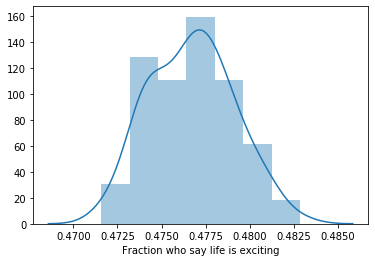

In [15]:
sns.distplot(resampled_means, axlabel='Fraction who say life is exciting');

This is the sampling distribution of the mean; it gives us a sense of how much we expect our estimate to vary due to random sampling.

The answer is, not very much.  Because the sample size is so large, variation due to random sampling is probably the least of our problems.

To summarize this distribution, we can compute the median, 5th, and 95th percentiles.

In [16]:
low, median, high = np.percentile(resampled_means, [5, 50, 95])

print(median, (low, high))

0.4767599105834961 (0.47336825728416443, 0.48064443469047546)


The 5th and 95th percentiles form a 90% confidence interval.

The median is a point estimate unbiased by stratified sampling.  In this example, it is not substantially different from the mean we computed from the unresampled data.

In [17]:
mean_exciting(gss)

0.47163752

As an alternative to a confidence interval, we could also compute a standard error, which is the standard deviation of the sampling distribution.

In [18]:
np.std(resampled_means)

0.002354511

But the standard error doesn't contain additional information beyond the confidence interval, and I think it is harder to interpret.  So I am generally inclined to report the CI along.

## Trend over time

Now let's see how the responses to this question are changing over time.

First I'll compute the mean response for each year.

In [19]:
gss_by_year = gss.groupby('year')
exciting_by_year = gss_by_year['is_exciting'].mean()

And plot the results.

In [20]:
def decorate(**options):
    """Decorate the current axes.
    Call decorate with keyword arguments like
    decorate(title='Title',
             xlabel='x',
             ylabel='y')
    The keyword arguments can be any of the axis properties
    https://matplotlib.org/api/axes_api.html
    """
    ax = plt.gca()
    ax.set(**options)
    handles, labels = ax.get_legend_handles_labels()
    if labels:
        plt.legend()
    plt.tight_layout()

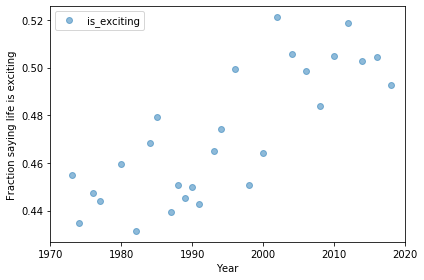

In [21]:
exciting_by_year.plot(style='o', alpha=0.5)

decorate(xlabel='Year',
         ylabel='Fraction saying life is exciting',
         xlim=[1970, 2020])

It looks like more people think life is exciting over time, but since the data are quite noisy, we might wonder if this observation is reliable.

To answer that, I'll use logistic regression to estimate the parameter associated with time, and use resampling to quantify the precision of that estimate.

## Resampled parameters

I'll use StatsModels to compute the parameters of a logistic regression.

In [22]:
import statsmodels.formula.api as smf

results = smf.logit('is_exciting ~ year', data=gss).fit()

Optimization terminated successfully.
         Current function value: 0.690640
         Iterations 4


In [23]:
results.params

Intercept   -12.671421
year          0.006296
dtype: float64

The parameter of `year` is a log-odds ratio that indicates how the fraction of positive responses increases from one year to the next.

To see what the regression line looks like, I'll generate predictions for a range of years.

In [36]:
df_pred = pd.DataFrame()
years = np.arange(1972, 2019)
df_pred['year'] = years
pred = results.predict(df_pred)

The following plot shows the original data and the logistic regression line.

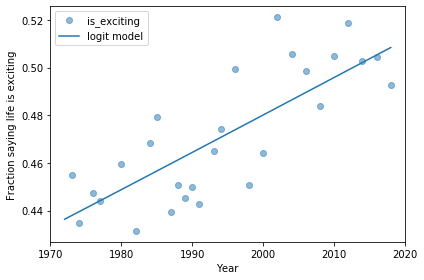

In [38]:
exciting_by_year.plot(style='o', alpha=0.5)
plt.plot(years, pred, color='C0', label='logit model')

decorate(xlabel='Year',
         ylabel='Fraction saying life is exciting',
         xlim=[1970, 2020])

The regression line is not actually a straight line, but in the range of probabilities near 0.5, a logistic curve appears as a nearly straight line.

To make it easier to resample this result, I'll use the following function, which takes a resampled `DataFrame` and returns the LOR for one year.

In [39]:
def estimate_lor(df):
    results = smf.logit('is_exciting ~ year', data=df).fit(disp=0)
    return results.params['year']

Now we call this function with each resampling, and plot the results.

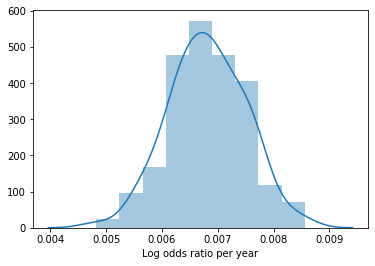

In [40]:
resampled_params = [estimate_lor(df) for df in resampled_dfs]

sns.distplot(resampled_params, axlabel='Log odds ratio per year');

This figure shows the sampling distribution of the estimated parameter.  In every resampling, the estimate is positive, which suggests that the slope we see in the data is probably not due to random sampling.

To summarize the distribution, we can use the mean:

In [41]:
np.mean(resampled_params)

0.006810176484606039

Or, as in the previous example, the median and a 90% CI.

In [42]:
low, median, high = np.percentile(resampled_params, [5, 50, 95])

print(median, (low, high))

0.006814480320533563 (0.005698731722232167, 0.007790602070529365)


The standard deviation of the sampling distribution is the standard error.

In [43]:
np.std(resampled_params)

0.0006762217562391258

So far we've computed point estimates and confidence intervals for the mean and the log odds ratio.  We can use the same tools to show how the predictions vary due to random sampling.

## Resampled predictions

The following function takes a resampled `DataFrame`, fits a logistic regression model, and generates predictions for a range of dates, including projections into the near future.

In [44]:
df_pred = pd.DataFrame()
years = np.arange(1972, 2023)
df_pred['year'] = years

def make_predictions(df):
    results = smf.logit('is_exciting ~ year', data=df).fit(disp=0)
    pred = results.predict(df_pred)    
    return pred

We can use this function to compute predictions for each resampled `DataFrame`:

In [45]:
resampled_preds = [make_predictions(df) for df in resampled_dfs]

The result is a list of arrays, which we can think of as a 2-D array with one rows for each resampling and one column for each year.

If we compute percentiles along `axis=0`, we'll get percentiles from each column.

In [46]:
low, med, high = np.percentile(resampled_preds, [5, 50, 95], axis=0)

So `low`, `med`, and `high` are arrays with the same length as `years`, which we can plot like this.

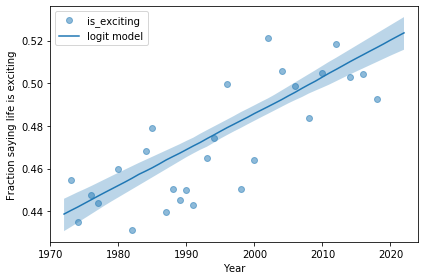

In [47]:
exciting_by_year.plot(style='o', alpha=0.5)
plt.fill_between(years, low, high, alpha=0.3)
plt.plot(years, med, color='C0', label='logit model')

decorate(xlabel='Year',
         ylabel='Fraction saying life is exciting',
         xlim=[1970, 2024])

The shaded area shows the 90% CI for each year; the solid line shows the median.

Most of the data points don't fall in the CI, but that's OK; we should not expect them to.  This CI shows uncertainty in the model due to random sampling, but it does not include the variation from year to year that we see in the data.

## Summary

This notebook demonstrates a process for using resampling to quantify uncertainty in estimated parameters due to random sampling.  The key steps of this process are:

1. Generate a collection of resampled `DataFrame`s.

2. Write a function that takes a `DataFrame` and returns an estimate of some kind.

3. Run the function with each resampling and collect the results.

4. Plot the results as a sampling distribution or summarize it using a mean, median, confidence interval, or standard error.

We applied this process to estimating a mean, estimating a regression parameter, and generating predictions from a regression model.
